# Denmark - Infer parameters

In [83]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [84]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pyross
import time 
import pandas as pd

We use the Denmark age structure and contact matrix as well as the real data to infer parameters from the different model implemented in Pyross. 

**Summary:**

1. We briefly summarize each model starting with the SIIR model.
2. We load the age structure and contact matrix for Denmark. The contact matrix is given as
\begin{equation}
    C = C_{H} + C_{W} + C_{S} + C_{O},
\end{equation}
where the four terms denote the number of contacts at home, work, school, and all other remaining contacts.
3. We are using real data (the number of case in Denmark) to fit parameters from each model.  




## Import all the relevant Denmark data

In [3]:
my_data = np.genfromtxt('../data/age_structures/Denmark-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;

M=16  ## number of age classes

Ni = Ni0[:M]
N=np.sum(Ni)

print("Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).")
print("Number of individuals in each bracket:")
print(Ni.astype('int'))
print("Total number of individuals: {0}".format(np.sum(Ni.astype('int'))))

Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).
Number of individuals in each bracket:
[302353 305513 338779 341219 379522 395469 342443 320132 366147 385944
 422585 381360 338039 319145 346572 220374]
Total number of individuals: 5505596


In [4]:
Ni

array([302353., 305513., 338779., 341219., 379522., 395469., 342443.,
       320132., 366147., 385944., 422585., 381360., 338039., 319145.,
       346572., 220374.])

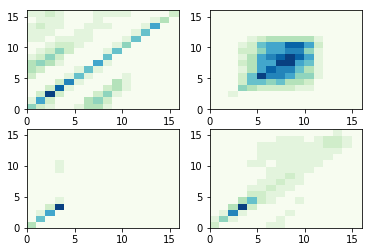

In [5]:
# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.Denmark()

# By default, home, work, school, and others contribute to the contact matrix
C = CH + CW + CS + CO

# Illustrate the individual contact matrices:
fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

C is the sum of contributions from contacts at home, workplace, schools and all other public spheres. Using superscripts $H$, $W$, $S$ and $O$ for each of these, we write the contact matrix as
$$
C_{ij} = C^H_{ij} + C^W_{ij} + C^S_{ij} + C^O_{ij}
$$

We read in these contact matrices from the data sets provided in the paper *Projecting social contact matrices in 152 countries using contact surveys and demographic data* by Prem et al, sum them to obtain the total contact matrix. We also read in the age distribution of UK obtained from the *Population pyramid* website.

In [8]:
denmark_age_structured_case = pd.read_csv('../../denmark_cases_by_age.csv')
case = denmark_age_structured_case.sum(axis=0)[1:]

In [10]:
## infective people - remove pp 80 years old + - no contact matrices
nbday = denmark_age_structured_case.shape[1]-1
nbgroup = denmark_age_structured_case.shape[0]
I = np.array(np.zeros([nbday, nbgroup-2]))
for i in range(1,nbday+1):
    I[i-1] = np.array([denmark_age_structured_case.iloc[:,i][:nbgroup-2]])

In [13]:
# Get the latest data from Johns Hopkins University
!git clone https://github.com/CSSEGISandData/COVID-19

fatal: destination path 'COVID-19' already exists and is not an empty directory.


In [14]:
cases = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
cols = cases.columns.tolist() 
case = cases.loc[94,][4:]

In [15]:
# march 13 - 52

In [16]:
## adding to the data the 11 previous day to have consistent increasing cases number
I1 = np.array(np.zeros([nbday+11, 8]))
I1[0]=np.array([[ 0.,  0., 1., 2., 0., 1.,  0.,   0.]])
I1[1] = np.array([[ 0.,  0., 1., 3., 0., 2.,  0.,   0.]])
I1[2] =np.array([[ 0.,  1., 2., 3., 1., 2.,  1.,   0.]])
I1[3] =np.array([[ 0.,  1., 2., 3., 1., 2.,  1.,   0.]])
I1[4] =np.array([[ 1.,  2., 4., 5., 4., 4.,  2.,   1.]])
I1[5] =np.array([[ 1.,  2., 4., 5., 4., 4.,  2.,   1.]])
I1[6] =np.array([[ 2.,  3., 4., 7., 6., 6.,  4.,   3.]])
I1[7] =np.array([[ 4.,  9., 16., 19., 15., 12.,12.,   3.]])
I1[8] =np.array([[ 6.,  13., 42., 60., 75., 39.,24.,   3.]])
I1[9] =np.array([[ 7.,  18., 78., 98., 120., 79.,38.,   4.]])
I1[10] =np.array([[ 9.,  28., 101., 121., 187., 119.,46.,   4.]])
I1[11:] = I
I = I1
## we don't want a cum sum 
I[1:] -= I[:-1].copy()
# weird mistake , negative number
I[14,0] = 1

In [17]:
##  duplicate for each subgroup of age 
M = 16
Is = np.array(np.zeros([nbday+11, M]))
for i in range(I.shape[0]):
    Is[i] = np.array([val for val in I[i]/2 for _ in (0, 1)])

    
## take only integer values, loosing cases !
for j in range(Is.shape[0]):
    Is[j] = np.array([int(i) for i in Is[j]])

## SIIR model 



In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given **real data** from Denmark for :
* $S$ (number of susceptible individual), 
* $Is$ (number of symptomatic infected individual until May 5th), 
* $Ia$ (number of asymptomatic individual consider equal to Is), 




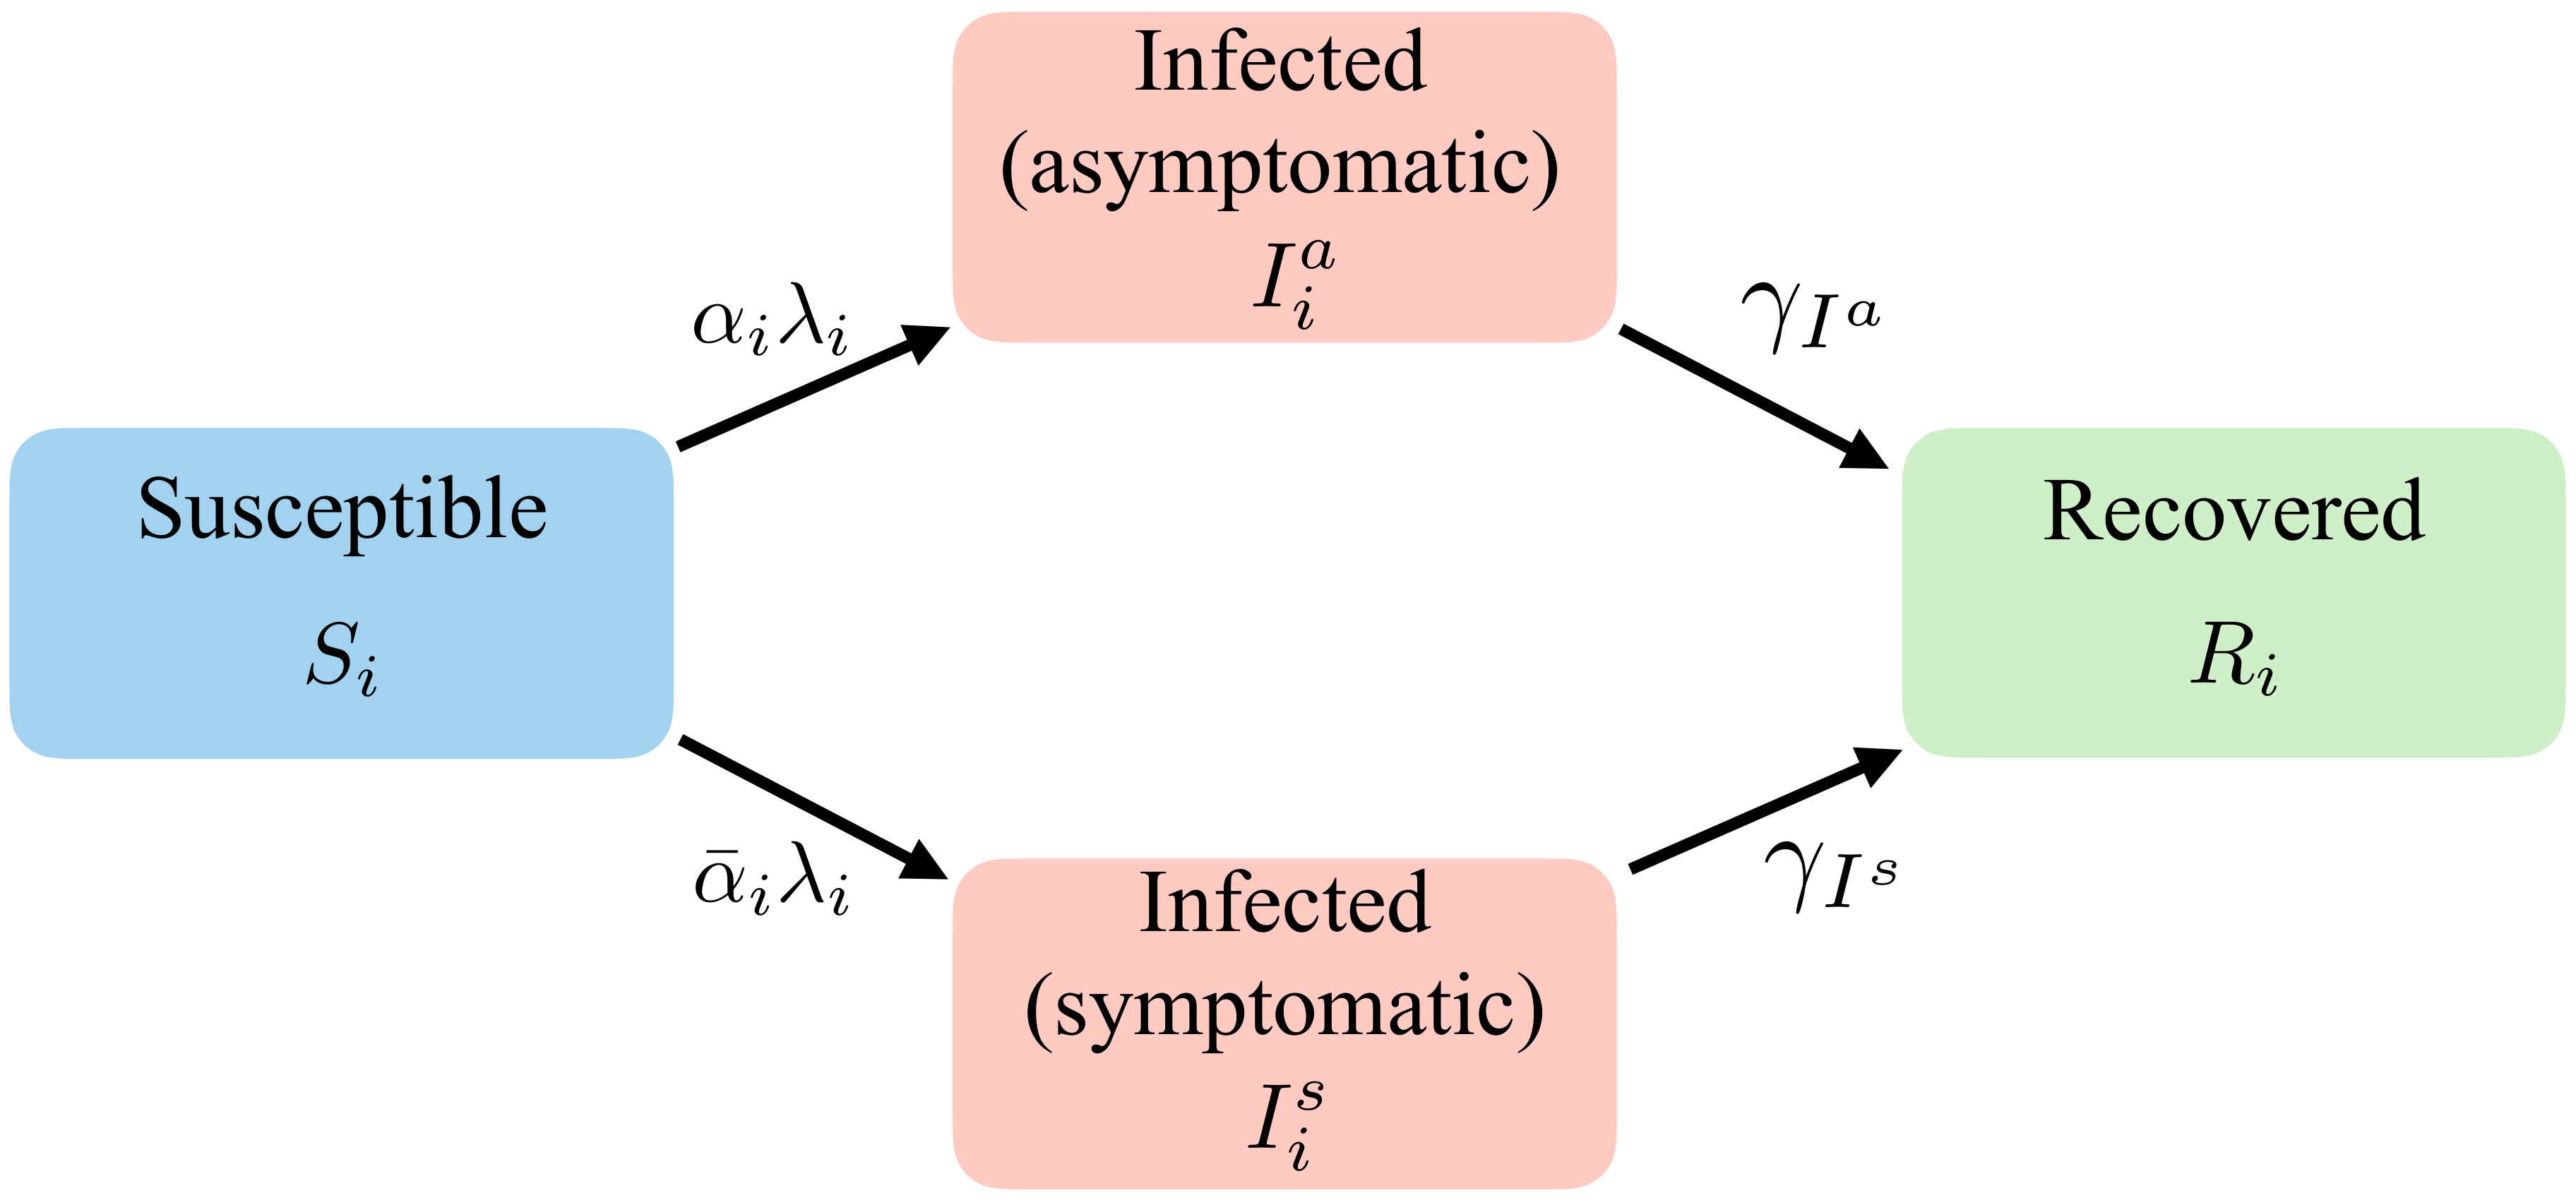

In [18]:
from IPython.display import Image
Image('SIIR.jpg')

### 1) Let's create 3 groups 

In [19]:
## young 0-20 years
## medium 20-50 years
## senior 50-80 years

In [20]:
M = 3
Ismod = np.array(np.zeros([nbday+11, M]))
for i in range(nbday+11):
    Ismod[i,0] = sum(Is[i,0:5])
    Ismod[i,1] = sum(Is[i,4:10])
    Ismod[i,2] = sum(Is[i,11:16])

In [21]:
## contact matrix
C1 = np.array(np.zeros([M, M]))
C1[0,0] = int(sum(C[0:5,0:5]).sum())
C1[0,1] = int(sum(C[0:5,4:10]).sum())
C1[0,2] = int(sum(C[0:5,11:16]).sum())
C1[1,0] = int(sum(C[4:10,0:5]).sum())
C1[1,1] = int(sum(C[4:10,4:10]).sum())
C1[1,2] = int(sum(C[4:10,11:16]).sum())
C1[2,0] = int(sum(C[11:16,0:5]).sum())
C1[2,1] = int(sum(C[11:16,4:10]).sum())
C1[2,2] = int(sum(C[11:16,11:16]).sum())

In [22]:
C = C1

In [23]:
Nimod = np.array(np.zeros([M]))
Nimod[0] = sum(Ni[0:5])
Nimod[1] = sum(Ni[4:10])
Nimod[2] = sum(Ni[11:16])

In [24]:
Ni = Nimod

In [85]:
N=np.sum(Ni)
N

5462533.0

#### 1)a) Run one simulation 
We generate a test trajectory on a population with two ages groups.

In [62]:
beta  = 0.01     # infection rate 

gIa   = 1./3.                # recovery rate of asymptomatic infectives 
gIs   = 1./3.                # recovery rate of symptomatic infectives 
alpha = 0.4          # fraction of asymptomatic infectives 
fsa   = 0.3    

# initial conditions    
Is0 = np.array([2, 2, 2])
Ia0 = np.array([2, 2, 2])
R0  = np.zeros((M))
S0  = Ni - (Ia0 + Is0 + R0)

In [63]:
## matrix with all events
def contactMatrix(t):
    return C

In [64]:
fi = Ni/sum(Ni)

In [65]:
# fraction of population in Age group
Ni = N*fi

#### 1)b) Model

In [66]:
print('M :', M)
print('Ni :', Ni)
print('N :', N)
print('C :', C)
print('Ia0 :', Ia0)
print('Is0 :', Is0)
print('S0 :', S0)
print('R0 :', R0)

M : 3
Ni : [1667386. 2189657. 1605490.]
N : 5462533.0
C : [[44. 26.  2.]
 [26. 59.  5.]
 [ 9. 16. 14.]]
Ia0 : [2 2 2]
Is0 : [2 2 2]
S0 : [1667382. 2189653. 1605486.]
R0 : [0. 0. 0.]


In [67]:
Tf = 150
Nf = Tf+1

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

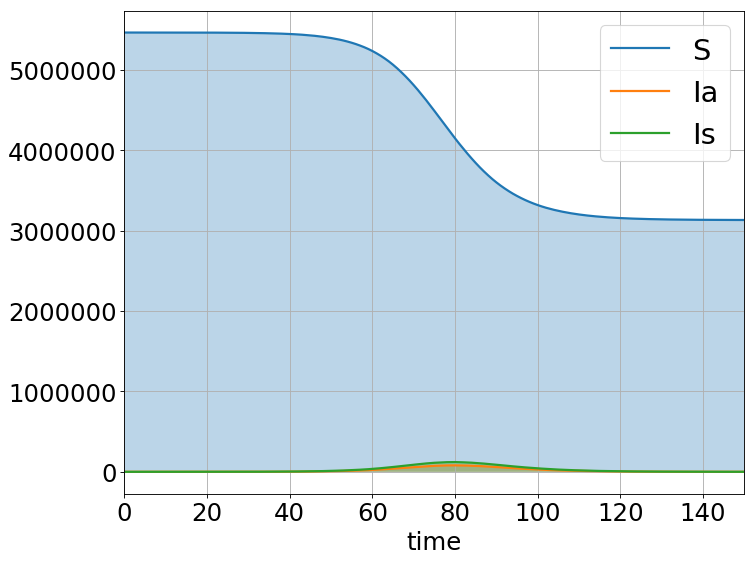

In [86]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=2)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

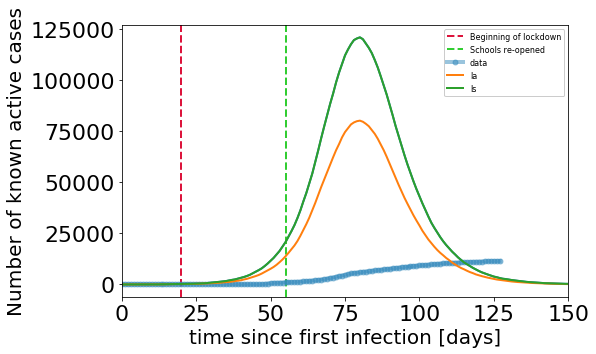

In [87]:
y_plot = np.sum(data_array[:, 2*M:3*M], axis=1)
lw=2
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(t,y_plot,lw=lw,)
ax.axvline(20,
           color='crimson',lw=lw,
          label='Beginning of lockdown',ls='--')
ax.axvline(55,
color='limegreen',lw=lw,
          label='Schools re-opened',ls='--')

ax.plot(np.array(case), 'o-', lw=4, color='#348ABD', ms=5, label='data', alpha=0.5)


plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=2)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=2)

ax.set_xlim(0,Tf)
fs=20
ax.legend(loc='best',fontsize=8,framealpha=1)
ax.set_xlabel('time since first infection [days]',fontsize=fs)
ax.set_ylabel('Number of known active cases',fontsize=fs)
# plt.show(fig)
plt.savefig('denmarkSIR.png')

The model is predicting too many infected individuals.

#### 1)c) Inference
We take the first real points and use them to infer the parameters of the model.

We assume the same number of symptomatic and asymptomatic individuals.

In [88]:
Tf_inference = 64
Nf_inference = Tf_inference+1

In [89]:
# load the oberved data
x = np.load('SIR_sto_traj.npy').astype('float')
x.shape
# x = (x/N)[:Nf_inference]

(151, 9)

In [90]:
dayobs = nbday+11

In [91]:
x[1:dayobs, 2*M:3*M] = Ismod[1:dayobs ,]
# x[1:dayobs, M:2*M] = Ismod[1:dayobs ,]
# x[1:dayobs,0:M]  = Ni - x[1:dayobs, M:2*M] - x[1:dayobs, 2*M:3*M]
x = (x/N)[:Nf_inference]
steps = 101

In [92]:
# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

367954.8124224418
0.34119391441345215


In [93]:
# Define the prior (Gamma prior around guess of parameter with defined std. deviation)
alpha_g = 0.3
beta_g = 0.02
gIa_g = 0.1
gIs_g = 0.1
fsa_g= 0.1

# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g, 'fsa':fsa_g}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
print(logp)

827796.99617319


In [94]:
# the names of the parameters to be inferred 
eps = 1e-4 
keys = ['alpha', 'beta', 'gIa', 'gIs']

# initial guess 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])  

# error bars on the initial guess 
alpha_std = 0.2
beta_std = 0.1
gIa_std = 0.1
gIs_std = 0.1
stds = np.array([alpha_std, beta_std , gIa_std, gIs_std])

# bounds on the parameters 
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)]) 

# Stopping criterion for minimisation (realtive change in function value)
ftol = 1e-6  
start_time = time.time() 
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf_inference, Nf_inference, 
                                    contactMatrix, 
                                    global_max_iter=20,
                                    local_max_iter=200, 
                                    global_ftol_factor=1e3, 
                                    ftol=ftol, 
                                    verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=2212580848, Wed Jun  3 17:14:50 2020)


Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
ValueError: Cov has negative determinant


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 3.721331160275696e+05 1.0e+00 8.44e-01  7e-02  2e-01 0:03.1
    2     32 3.218666597190848e+05 1.2e+00 8.37e-01  7e-02  2e-01 0:12.0
    3     48 3.435732811043398e+05 1.5e+00 6.39e-01  5e-02  1e-01 0:21.7
    4     64 3.809416067551735e+05 1.8e+00 6.74e-01  4e-02  1e-01 0:30.2
    5     80 3.435990883578743e+05 2.3e+00 5.14e-01  3e-02  1e-01 0:35.7
    6     96 2.844296902744054e+05 2.4e+00 6.84e-01  4e-02  2e-01 0:41.0
    8    128 2.080415888665728e+05 5.4e+00 1.12e+00  4e-02  3e-01 0:49.8
   10    160 1.084220272698482e+05 6.0e+00 1.29e+00  4e-02  3e-01 0:57.9
   13    208 7.413868906968871e+04 9.4e+00 1.55e+00  3e-02  2e-01 1:07.1
   17    272 6.757444267493341e+04 1.2e+01 1.34e+00  2e-02  1e-01 1:18.7
Optimal value (global minimisation):  56184.18359142253
Starting local minimisation...
Optimal value (local minimisation):  40912.14976427028
[0.8        0.01677197 0.6        0.59992088]
128.524363

In [95]:
# compute log_p for best estimate 
start_time = time.time() 
new_parameters = estimator.fill_params_dict(keys, params)
logp = estimator.obtain_minus_log_p(new_parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

40903.60708449021
0.5751838684082031


In [96]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(new_parameters)

True parameters:
{'alpha': 0.4, 'beta': 0.01, 'gIa': 0.3333333333333333, 'gIs': 0.3333333333333333, 'fsa': 0.3}

Inferred parameters:
{'alpha': 0.8, 'beta': 0.01677196896424667, 'gIa': 0.6, 'gIs': 0.5999208831891778, 'fsa': 0.1}


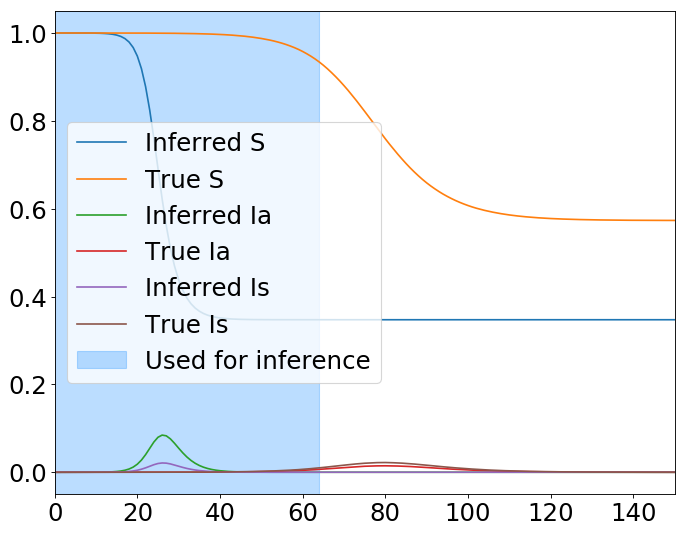

In [97]:
x = np.load('SIR_sto_traj.npy').astype('float')/N 
Nf = x.shape[0]
Tf = Nf-1

det_model = pyross.deterministic.SIR(new_parameters, int(M), fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Is')
plt.xlim([0, Tf])
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 

April 15, Denmark reopen schools